In [44]:
import pandas as pd
import numpy as np

# Step 1: Load Data
data = pd.read_csv('Dataset_122.csv', encoding='latin1')

# Step 2: Handle Missing Values
# Check for missing values
print(data.isnull().sum())

# Drop unnecessary columns
data = data.drop(columns=['Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7'])

# Impute missing values in 'Price' or drop rows with missing 'Units Sold'
data['Price'] = data['Price'].fillna(data['Price'].mean())
data = data.dropna(subset=['Units Sold'])

# Step 3: Remove Duplicates
data = data.drop_duplicates()

# Step 4: Data Type Conversion
# Handle inconsistent date formats
data['Date'] = pd.to_datetime(data['Date'], errors='coerce', dayfirst=True)
data = data.dropna(subset=['Date'])  # Drop rows where the date conversion failed

# Step 5: Handle Outliers
# Identify outliers
q1 = data['Units Sold'].quantile(0.25)
q3 = data['Units Sold'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Remove outliers
data = data[(data['Units Sold'] >= lower_bound) & (data['Units Sold'] <= upper_bound)]

# Step 6: Parse Dates
# Already converted in Step 4

# Step 7: Aggregation (if needed)
# Example: Aggregate data by day and product
daily_sales = data.groupby(['Product ID', 'Date']).agg({'Units Sold': 'sum', 'Price': 'mean'}).reset_index()

# Step 8: Feature Engineering
# Example: Adding day of the week as a feature
daily_sales['DayOfWeek'] = daily_sales['Date'].dt.dayofweek

# Step 9: Scaling and Normalization (if needed)
# Example: Normalize Units Sold
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
daily_sales['Units Sold'] = scaler.fit_transform(daily_sales[['Units Sold']])

# Final preprocessed data
print(daily_sales.head())


Product ID       14735
Product Name     15229
Units Sold       14735
Date             14735
Price            14735
Unnamed: 5      189668
Unnamed: 6      189668
Unnamed: 7      189668
dtype: int64
  Product ID                Date  Units Sold  Price  DayOfWeek
0      10002 2015-04-07 09:35:00    0.309524   1.63          1
1      10002 2015-04-24 23:39:00    0.309524   1.66          4
2      10002 2015-05-05 08:47:00    0.571429   0.85          1
3      10002 2015-05-24 15:03:00    0.571429   0.85          6
4      10002 2015-06-03 19:26:00    0.309524   0.85          2


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib


In [45]:

# Step 1: Load Data
data = pd.read_csv('Dataset_122.csv', encoding='latin1')

# Step 2: Handle Missing Values
# Drop unnecessary columns
data = data.drop(columns=['Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7'])

In [46]:

# Impute missing values in 'Price' or drop rows with missing 'Units Sold'
data['Price'] = data['Price'].fillna(data['Price'].mean())
data = data.dropna(subset=['Units Sold'])

# Step 3: Remove Duplicates
data = data.drop_duplicates()


In [47]:

# Step 4: Data Type Conversion
# Handle inconsistent date formats
data['Date'] = pd.to_datetime(data['Date'], errors='coerce', dayfirst=True)
data = data.dropna(subset=['Date'])  # Drop rows where the date conversion failed

# Step 5: Handle Outliers
# Identify outliers
q1 = data['Units Sold'].quantile(0.25)
q3 = data['Units Sold'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

In [14]:

# Remove outliers
data = data[(data['Units Sold'] >= lower_bound) & (data['Units Sold'] <= upper_bound)]

# Step 6: Parse Dates
# Already converted in Step 4

# Step 7: Aggregation (if needed)
# Example: Aggregate data by day and product
daily_sales = data.groupby(['Product ID', 'Date']).agg({'Units Sold': 'sum', 'Price': 'mean'}).reset_index()

# Step 8: Feature Engineering
# Adding day of the week as a feature
daily_sales['DayOfWeek'] = daily_sales['Date'].dt.dayofweek

In [15]:
# Step 9: Scaling and Normalization (if needed)
# Normalize Units Sold
scaler = MinMaxScaler()
daily_sales['Units Sold'] = scaler.fit_transform(daily_sales[['Units Sold']])

# Encoding Categorical Features
# Convert 'Product ID' to numeric using Label Encoding
label_encoder = LabelEncoder()
daily_sales['Product ID'] = label_encoder.fit_transform(daily_sales['Product ID'])

In [20]:
# Feature Engineering: Lag features, rolling statistics, and additional date features
daily_sales['Lag_1'] = daily_sales['Units Sold'].shift(1)
daily_sales['Lag_7'] = daily_sales['Units Sold'].shift(7)
daily_sales['Rolling_Mean_7'] = daily_sales['Units Sold'].rolling(window=7).mean()
daily_sales['Month'] = daily_sales['Date'].dt.month
daily_sales['Quarter'] = daily_sales['Date'].dt.quarter

# Drop NaN values created by lag features
daily_sales.dropna(inplace=True)

# Split data into training and testing sets
features = daily_sales.drop(columns=['Units Sold', 'Date'])
target = daily_sales['Units Sold']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

In [25]:
# Assuming daily_sales is your DataFrame with necessary features
X = daily_sales.drop(columns=['Units Sold', 'Date'])
y = daily_sales['Units Sold']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Reduce the number of estimators for faster training
model = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=10, random_state=42)

In [26]:
# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f'Training RMSE: {train_rmse}')
print(f'Testing RMSE: {test_rmse}')
print(f'Training MAE: {train_mae}')
print(f'Testing MAE: {test_mae}')

Training RMSE: 0.08475959365065795
Testing RMSE: 0.08587734231458698
Training MAE: 0.06180460642147902
Testing MAE: 0.06163940379912567


C:\Users\nikit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\nikit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [30]:
# Import necessary libraries
import pandas as pd
from pandas.tseries.offsets import DateOffset

# Get the last date from the existing data
last_date = daily_sales['Date'].max()

# Generate future dates for the next 5 years (e.g., daily frequency)
future_dates = pd.date_range(start=last_date, periods=5*365, freq='D')


In [31]:
# Create a DataFrame for future dates
future_data = pd.DataFrame({'Date': future_dates})

# Feature engineering for future dates
future_data['DayOfWeek'] = future_data['Date'].dt.dayofweek
# Add other necessary features here based on your model (e.g., month, day of year)
# future_data['Month'] = future_data['Date'].dt.month
# future_data['DayOfYear'] = future_data['Date'].dt.dayofyear


In [43]:
import pandas as pd

# Load your dataset
data = pd.read_csv('Dataset_112.csv', encoding='latin1')

# Reduce the number of rows by random sampling
sampled_data = data.sample(frac=0.7, random_state=42)  # Adjust 'frac' as needed, e.g., 0.1 for 10% of the data

# Save the reduced dataset to a new file
sampled_data.to_csv('Dataset_122.csv', index=False)


In [67]:
import pandas as pd
import re

# Step 1: Load the dataset
data = pd.read_csv('Dataset_122.csv', encoding='latin1')  # Adjust the path and encoding as needed

# Step 2: Define categories and keywords
keywords = {
   'BAG': 'Bags',
    'DECORATION': 'Decorations',
    'CHALKBOARD': 'Chalkboards',
    'CARD': 'Cards',
    'GIFT': 'Gifts',
    'RACK': 'Racks',
    'TIN': 'Tins',
    'BOWL': 'Bowls',
    'GLOVES': 'Gloves',
    'CANDLE': 'Candles',
    'CHILDRENS': 'Children Items',
    'AIRLINE': 'Airline Items',
    'HEART': 'Heart Items',
    'CHRISTMAS': 'Christmas Decorations',
    'TEA': 'Kitchen and Dining',
    'HOME': 'Home Decor',
    'PENCIL': 'Stationery and Crafts',
    'APRON': 'Clothing and Accessories',
    'CUSHION': 'Miscellaneous',
    'DOORMAT': 'Home Decor',
    'BISCUIT TIN': 'Kitchen and Dining',
    'MUG': 'Kitchen and Dining',
    'LIGHT': 'Home Decor',
    'OWL': 'Home Decor',
    'DOLL': 'Toys and Gifts',
    'NIGHT LIGHT': 'Home Decor',
    'SIGN': 'Home Decor',
    'BAKING SET': 'Kitchen and Dining',
    'LUNCH BOX': 'Kitchen and Dining',
    'CUSHION COVER': 'Home Decor',
    'PLATE': 'Kitchen and Dining',
    'BOX': 'Storage and Organization',
    'PAPER': 'Stationery and Crafts',
    'JEWELLERY': 'Home Decor',
    'TEAPOT': 'Kitchen and Dining',
    'CASES': 'Kitchen and Dining',
    'GARLAND': 'Home Decor',
    'POSTAGE': 'Stationery and Crafts',
    'CUTLERY': 'Kitchen and Dining',
    'SET': 'Various',
    'HOLDER': 'Home Decor',
    'POT': 'Home Decor',
    'COVER': 'Accessories',
    'HOOK': 'Home Decor',
    'BOARD': 'Home Decor',
    'BRUSH': 'Home Decor',
    'KITCHEN': 'Home Decor',
    'TOY': 'Toys and Gifts',
    'TRAVEL': 'Travel Accessories',
    'COAT RACK': 'Home Decor',
    'WALL CLOCK': 'Home Decor',
    'NECKLACE': 'Accessories',
    'TABLE': 'Home Decor',
    'KIT': 'Stationery and Crafts',
    'WASHING UP': 'Kitchen and Dining',
    'T-LIGHT': 'Home Decor',
    'TRINKET POT': 'Home Decor',
    'SNACK BOXES': 'Kitchen and Dining',
    'DRAWER': 'Furniture',
    'BOTTLE': 'Home Decor',
    'BUNTING': 'Home Decor',
    'CASE': 'Storage and Organization',
    'STICKS': 'Toys and Gifts',
    'DISH': 'Home Decor',
    'MODELING CLAY': 'Crafts',
    'PLAQUE': 'Home Decor',
    'PENCILS': 'Stationery and Crafts',
    'GARDEN': 'Home Decor',
    'CABINET': 'Furniture',
    'GAME': 'Toys and Gifts',
    'LID': 'Kitchen and Dining',
    'ART': 'Home Decor',
    'JUMBO': 'Storage and Organization',
    'GUM BALL': 'Home Decor',
    'WRAP': 'Stationery and Crafts',
    'LETTERS': 'Home Decor',
    'FAN': 'Accessories',
    'LADDER': 'Home Decor',
    'REEL': 'Stationery and Crafts',
    'NOTEBOOK': 'Stationery',
    'SLATE': 'Stationery and Crafts',
    'SPOON': 'Kitchen and Dining',
    'FLAGS': 'Decorations',
    'CAKESTAND': 'Kitchen and Dining',
    'RIBBONS': 'Crafts',
    ' FAIRY FLOWER': 'Kitchen and Dining'

}

# Step 3: Filter out rows where 'Product Name' is not a string or is NaN
data = data[data['Product Name'].apply(lambda x: isinstance(x, str))].copy()
data['Product Name'] = data['Product Name'].fillna('')

# Step 4: Function to categorize based on keywords
def categorize_product(name):
    for keyword, category in keywords.items():
        if keyword in name.upper():
            return category
    return 'Other'

# Step 5: Apply categorization
data['Category'] = data['Product Name'].apply(categorize_product)

# Step 6: Save the categorized data
data.to_csv('c_products.csv', index=False)

# Display the first few rows of the categorized data
print(data.head())

# Check the number of uncategorized products
uncategorized_count = data[data['Category'] == 'Other'].shape[0]
print(f"Number of Uncategorized Products: {uncategorized_count}")


  Product ID                   Product Name  Units Sold              Date  \
1      22423       REGENCY CAKESTAND 3 TIER         2.0  03-03-2016 19:18   
2      23208  LUNCH BAG VINTAGE LEAF DESIGN         1.0  26-02-2017 11:16   
3     85099B        JUMBO BAG RED RETROSPOT         1.0  19-12-2017 01:32   
4      22030         SWALLOWS GREETING CARD        12.0  22-03-2017 02:28   
5      22859       EASTER TIN BUNNY BOUQUET         6.0  15-04-2015 09:42   

   Price  Unnamed: 5  Unnamed: 6  Unnamed: 7            Category  
1  24.96         NaN         NaN         NaN  Kitchen and Dining  
2   1.65         NaN         NaN         NaN                Bags  
3   2.08         NaN         NaN         NaN                Bags  
4   0.42         NaN         NaN         NaN               Cards  
5   1.65         NaN         NaN         NaN                Tins  
Number of Uncategorized Products: 30503


In [68]:
!pip install matplotlib



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: C:\Users\nikit\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [89]:
import pandas as pd
import re

# Step 1: Load the dataset
data = pd.read_csv('filtered_c_products.csv', encoding='latin1')  # Adjust the path and encoding as needed

# Step 2: Define categories and keywords (revised)
keywords = {
    'BAG': 'Bags and Travel Acc.',  # Combined 'Bags' and 'Travel Accessories'
    'DECORATION': 'Gift',
    'CHALKBOARD': 'Gift',
    'CARD': 'Stationery and Crafts',
    'GIFT': 'Gift',
    'RACK': 'Storage and Organization',
    'TIN': 'Tins',
    'BOWL': 'Kitchen and Dining',
    'GLOVES': 'Clothing and Accessories',
    'CANDLE': 'Home Decor',
    'CHILDRENS': 'Children Items',
    'AIRLINE': 'Bags and Travel Acc.',  # Combined 'Bags' and 'Travel Accessories'
    'CHRISTMAS': 'Christmas Decorations',
    'TEA': 'Kitchen and Dining',
    'HOME': 'Home Decor',
    'PENCIL': 'Stationery and Crafts',
    'APRON': 'Clothing and Accessories',
    'CUSHION': 'Home Decor',
    'DOORMAT': 'Home Decor',
    'BISCUIT TIN': 'Kitchen and Dining',
    'MUG': 'Kitchen and Dining',
    'LIGHT': 'Home Decor',
    'OWL': 'Home Decor',
    'DOLL': 'Children Items',
    'NIGHT LIGHT': 'Home Decor',
    'SIGN': 'Home Decor',
    'BAKING SET': 'Kitchen and Dining',
    'LUNCH BOX': 'Kitchen and Dining',
    'CUSHION COVER': 'Home Decor',
    'PLATE': 'Kitchen and Dining',
    'BOX': 'Storage and Organization',
    'PAPER': 'Stationery and Crafts',
    'JEWELLERY': 'Clothing and Accessories',
    'TEAPOT': 'Kitchen and Dining',
    'CASES': 'Storage and Organization',
    'GARLAND': 'Home Decor',
    'POSTAGE': 'Stationery and Crafts',
    'CUTLERY': 'Kitchen and Dining',
    'SET': 'Various',
    'HOLDER': 'Home Decor',
    'POT': 'Home Decor',
    'COVER': 'Clothing and Accessories',
    'HOOK': 'Home Decor',
    'BOARD': 'Home Decor',
    'BRUSH': 'Home Decor',
    'KITCHEN': 'Kitchen and Dining',
    'TOY': 'Children Items',
    'TRAVEL': 'Bags and Travel Acc.',  # Combined 'Bags' and 'Travel Accessories'
    'COAT RACK': 'Storage and Organization',
    'WALL CLOCK': 'Home Decor',
    'NECKLACE': 'Clothing and Accessories',
    'TABLE': 'Home Decor',
    'KIT': 'Stationery and Crafts',
    'WASHING UP': 'Kitchen and Dining',
    'T-LIGHT': 'Home Decor',
    'TRINKET POT': 'Home Decor',
    'SNACK BOXES': 'Kitchen and Dining',
    'DRAWER': 'Storage and Organization',
    'BOTTLE': 'Kitchen and Dining',
    'BUNTING': 'Gift',
    'CASE': 'Storage and Organization',
    'STICKS': 'Children Items',
    'DISH': 'Kitchen and Dining',
    'MODELING CLAY': 'Stationery and Crafts',
    'PLAQUE': 'Home Decor',
    'PENCILS': 'Stationery and Crafts',
    'GARDEN': 'Home Decor',
    'CABINET': 'Storage and Organization',
    'GAME': 'Children Items',
    'LID': 'Kitchen and Dining',
    'ART': 'Home Decor',
    'JUMBO': 'Storage and Organization',
    'GUM BALL': 'Kitchen and Dining',
    'WRAP': 'Stationery and Crafts',
    'LETTERS': 'Stationery and Crafts',
    'FAN': 'Home Decor',
    'LADDER': 'Home Decor',
    'REEL': 'Stationery and Crafts',
    'NOTEBOOK': 'Stationery and Crafts',
    'SLATE': 'Stationery and Crafts',
    'SPOON': 'Kitchen and Dining',
    'FLAGS': 'Gift',
    'CAKESTAND': 'Kitchen and Dining',
    'RIBBONS': 'Stationery and Crafts',
    ' FAIRY FLOWER': 'Kitchen and Dining'
}

# Step 3: Filter out rows where 'Product Name' is not a string or is NaN
data = data[data['Product Name'].apply(lambda x: isinstance(x, str))].copy()
data['Product Name'] = data['Product Name'].fillna('')

# Step 4: Function to categorize based on keywords
def categorize_product(name):
    for keyword, category in keywords.items():
        if keyword in name.upper():
            return category
    return 'Other'

# Step 5: Apply categorization
data['Category'] = data['Product Name'].apply(categorize_product)

# Step 6: Filter out rows where 'Category' is 'Other'
filtered_data = data[data['Category'] != 'Other']

# Step 7: Save the categorized and filtered data
filtered_data.to_csv('c_products.csv', index=False)

# Display the first few rows of the categorized data
print(filtered_data.head())

# Check the number of uncategorized products
uncategorized_count = filtered_data[filtered_data['Category'] == 'Other'].shape[0]
print(f"Number of Uncategorized Products: {uncategorized_count}")


  Product ID                   Product Name  Units Sold              Date  \
0      22423       REGENCY CAKESTAND 3 TIER           2  03-03-2016 19:18   
1      23208  LUNCH BAG VINTAGE LEAF DESIGN           1  26-02-2017 11:16   
2     85099B        JUMBO BAG RED RETROSPOT           1  19-12-2017 01:32   
3      22030         SWALLOWS GREETING CARD          12  22-03-2017 02:28   
4      22859       EASTER TIN BUNNY BOUQUET           6  15-04-2015 09:42   

   Price               Category  Unnamed: 5  Unnamed: 6  Unnamed: 7  
0  24.96     Kitchen and Dining         NaN         NaN         NaN  
1   1.65   Bags and Travel Acc.         NaN         NaN         NaN  
2   2.08   Bags and Travel Acc.         NaN         NaN         NaN  
3   0.42  Stationery and Crafts         NaN         NaN         NaN  
4   1.65                   Tins         NaN         NaN         NaN  
Number of Uncategorized Products: 0


In [117]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Step 1: Load the dataset
data = pd.read_csv('c_products.csv')

# Step 2: Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format="%d-%m-%Y %H:%M")

# Step 3: Set 'Date' column as index for time series analysis
data.set_index('Date', inplace=True)

# Step 4: Group by 'Date' to get monthly sales
monthly_sales = data.resample('M')['Units Sold'].sum()

# Reset index to make date a column again
monthly_sales = monthly_sales.reset_index()


C:\Users\nikit\AppData\Local\Temp\ipykernel_3396\746605609.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.resample('M')['Units Sold'].sum()


In [138]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Step 1: Load the dataset (assuming 'c_products.csv' contains your data)
data = pd.read_csv('c_products.csv')

# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format="%d-%m-%Y %H:%M")

# Set 'Date' column as index for time series analysis
data.set_index('Date', inplace=True)

# Group by 'Date' to get monthly sales
monthly_sales = data.resample('M')['Units Sold'].sum()

# Reset index to make 'Date' a column again
monthly_sales = monthly_sales.reset_index()

# Creating features for modeling
monthly_sales['Year'] = monthly_sales['Date'].dt.year
monthly_sales['Month'] = monthly_sales['Date'].dt.month

# Drop 'Date' column as we have extracted 'Year' and 'Month'
monthly_sales.drop(['Date'], axis=1, inplace=True)


C:\Users\nikit\AppData\Local\Temp\ipykernel_3396\3733048226.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.resample('M')['Units Sold'].sum()


In [139]:
# Splitting data into features (X) and target (y)
X = monthly_sales.drop(['Units Sold'], axis=1)
y = monthly_sales['Units Sold']

# Using RandomForestRegressor for prediction
model = RandomForestRegressor()

# Fit the model on the entire dataset
model.fit(X, y)


RandomForestRegressor()

Predicted Sales for each month of 2022:
    Year  Month  Predicted Sales
0   2021      1         16773.96
1   2021      2         18750.73
2   2021      3         20427.14
3   2021      4         19971.99
4   2021      5         21290.31
5   2021      6         20229.78
6   2021      7         21176.61
7   2021      8         20999.05
8   2021      9         21029.26
9   2021     10         22128.18
10  2021     11         22541.75
11  2021     12         19706.32


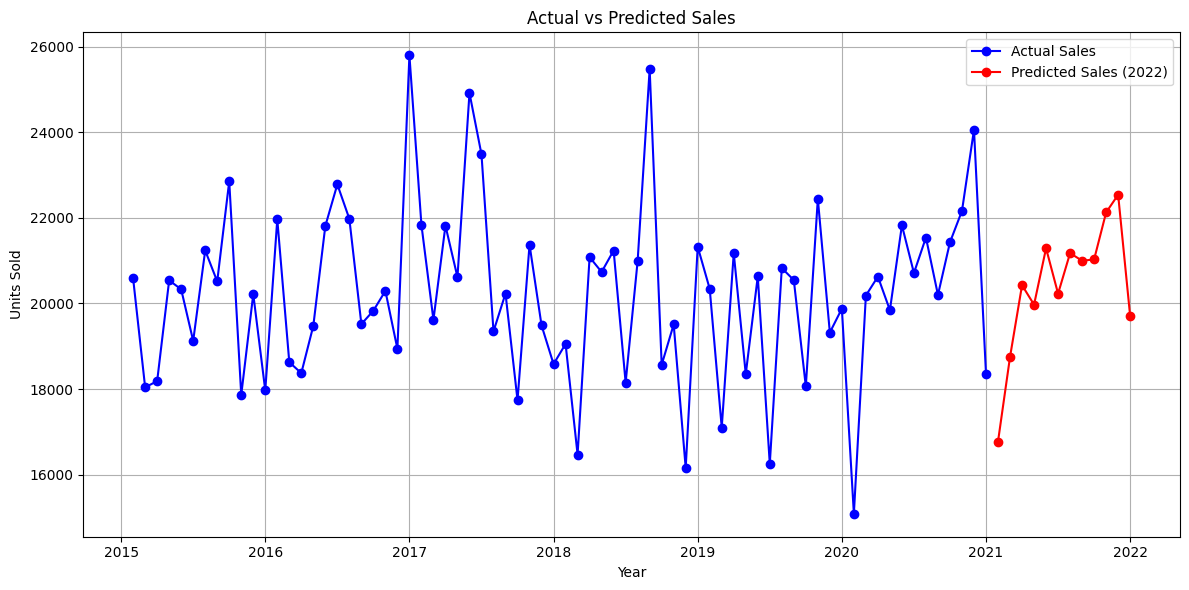

In [141]:
# Create future dates for prediction (each month of year 2022)
future_months_2022 = pd.DataFrame({'Year': [2021]*12,
                                   'Month': list(range(1, 13))})

# Predicting sales for each month of 2022
future_months_2022['Predicted Sales'] = model.predict(future_months_2022[['Year', 'Month']])

# Display predicted sales for each month of 2022
print("Predicted Sales for each month of 2022:")
print(future_months_2022)

# Plotting actual vs predicted sales
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['Year'] + monthly_sales['Month'] / 12, monthly_sales['Units Sold'], marker='o', linestyle='-', color='b', label='Actual Sales')
plt.plot(future_months_2022['Year'] + future_months_2022['Month'] / 12, future_months_2022['Predicted Sales'], marker='o', linestyle='-', color='r', label='Predicted Sales (2022)')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Year')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
